# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
### IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# # Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# # Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/cs682/assignment1'
%cd {notebook_folder}

Mounted at /content/drive
/content/drive/MyDrive/cs682/assignment1


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    # Don't forget to run get_datasets.sh, or this will throw an error
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs682.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [2.5e6, 2.5e7, 2.5e8]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
l_step_size = (learning_rates[1] - learning_rates[0]) / (5 - 1)
r_step_size = (regularization_strengths[1] - regularization_strengths[0]) / (5 - 1)
for l in list(np.arange(learning_rates[0],learning_rates[1],l_step_size)):
  for r in list(np.arange(regularization_strengths[0],regularization_strengths[1],r_step_size)):
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=l, reg=r, num_iters=1500, verbose=False)
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    training_accuracy = np.mean(y_train == y_train_pred)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[(l, r)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
      best_val = validation_accuracy
      best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 2.500000e+06 train accuracy: 0.142041 val accuracy: 0.149000
lr 1.000000e-09 reg 8.125000e+06 train accuracy: 0.413102 val accuracy: 0.421000
lr 1.000000e-09 reg 1.375000e+07 train accuracy: 0.410429 val accuracy: 0.406000
lr 1.000000e-09 reg 1.937500e+07 train accuracy: 0.407000 val accuracy: 0.396000
lr 3.250000e-09 reg 2.500000e+06 train accuracy: 0.414878 val accuracy: 0.417000
lr 3.250000e-09 reg 8.125000e+06 train accuracy: 0.414082 val accuracy: 0.420000
lr 3.250000e-09 reg 1.375000e+07 train accuracy: 0.405388 val accuracy: 0.393000
lr 3.250000e-09 reg 1.937500e+07 train accuracy: 0.403388 val accuracy: 0.411000
lr 5.500000e-09 reg 2.500000e+06 train accuracy: 0.409694 val accuracy: 0.410000
lr 5.500000e-09 reg 8.125000e+06 train accuracy: 0.398000 val accuracy: 0.386000
lr 5.500000e-09 reg 1.375000e+07 train accuracy: 0.399143 val accuracy: 0.404000
lr 5.500000e-09 reg 1.937500e+07 train accuracy: 0.379469 val accuracy: 0.369000
lr 7.750000e-09 reg 2.500000

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.409


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


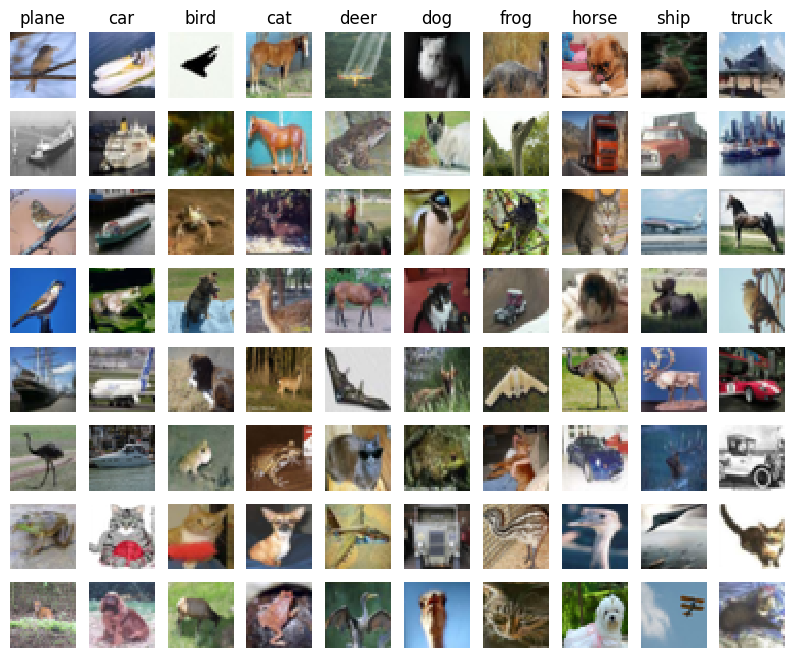

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

It makes sense, the misclassifications in the "plane" category could be due to the presence of a lot of sky and a bluish tinge in those images. Similarly, in the "car" category, the model might have confused some images of ships and trucks because they can resemble cars from certain angles. So, your observations align with the possible reasons for these misclassifications.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [10]:
from cs682.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val = -1

learning_rates = [1e-1, 5e-1]
regularization_strengths = [1e-3, 1e-2]

for l in learning_rates:
  for r in regularization_strengths:
      loss_hist = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=1000, batch_size=300, learning_rate=l, learning_rate_decay=0.95, reg=r, verbose=True)
      y_train_pred = net.predict(X_train_feats)
      y_val_pred = net.predict(X_val_feats)
      training_accuracy = np.mean(y_train == y_train_pred)
      validation_accuracy = np.mean(y_val == y_val_pred)
      results[(l, r)] = (training_accuracy, validation_accuracy)
      if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_net = net

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 2.303959
iteration 200 / 1000: loss 2.180512
iteration 300 / 1000: loss 1.817231
iteration 400 / 1000: loss 1.591887
iteration 500 / 1000: loss 1.552320
iteration 600 / 1000: loss 1.437471
iteration 700 / 1000: loss 1.507635
iteration 800 / 1000: loss 1.450657
iteration 900 / 1000: loss 1.402892
iteration 0 / 1000: loss 1.549972
iteration 100 / 1000: loss 1.545473
iteration 200 / 1000: loss 1.549225
iteration 300 / 1000: loss 1.491644
iteration 400 / 1000: loss 1.581915
iteration 500 / 1000: loss 1.529186
iteration 600 / 1000: loss 1.623114
iteration 700 / 1000: loss 1.499197
iteration 800 / 1000: loss 1.561397
iteration 900 / 1000: loss 1.521850
iteration 0 / 1000: loss 1.356873
iteration 100 / 1000: loss 1.397291
iteration 200 / 1000: loss 1.351317
iteration 300 / 1000: loss 1.278482
iteration 400 / 1000: loss 1.227348
iteration 500 / 1000: loss 1.177448
iteration 600 / 1000: loss 1.281118
iteration 700 / 1000: loss 1.20065

In [12]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.499


In [ ]:
!bash collectSubmission.sh

  adding: readme.md (deflated 28%)
  adding: .DS_Store (deflated 97%)
  adding: cs682/ (stored 0%)
  adding: cs682/__init__.py (stored 0%)
  adding: cs682/vis_utils.py (deflated 61%)
  adding: cs682/data_utils.py (deflated 67%)
  adding: cs682/features.py (deflated 60%)
  adding: cs682/gradient_check.py (deflated 66%)
  adding: cs682/.DS_Store (deflated 96%)
  adding: cs682/classifiers/ (stored 0%)
  adding: cs682/classifiers/__init__.py (deflated 38%)
  adding: cs682/classifiers/k_nearest_neighbor.py (deflated 79%)
  adding: cs682/classifiers/linear_classifier.py (deflated 72%)
  adding: cs682/classifiers/linear_svm.py (deflated 73%)
  adding: cs682/classifiers/softmax.py (deflated 73%)
  adding: cs682/classifiers/neural_net.py (deflated 73%)
  adding: two_layer_net.ipynb (deflated 25%)
  adding: knn.ipynb